[nltk_data] Downloading package cmudict to /usr/share/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!
Preprocessing complete. Training and validation data saved to '/kaggle/working/processed_poetry_train_dataset.csv' and '/kaggle/working/processed_poetry_val_dataset.csv'.


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


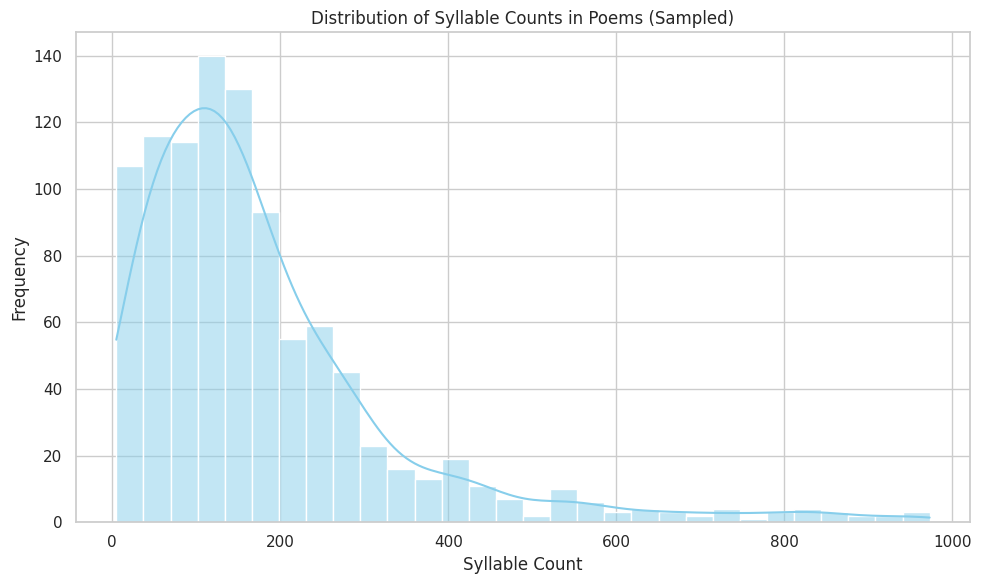

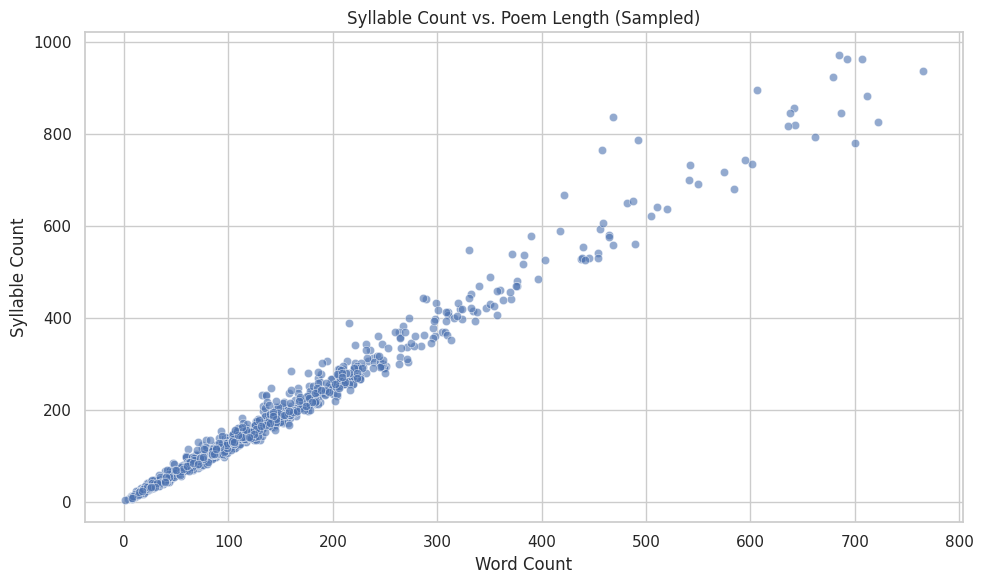

In [ ]:
import os
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

sns.set(style="whitegrid")

dataset_path = '/kaggle/input/poemsdataset'

poem_texts = []
form_labels = []
topic_labels = []
syllable_counts = []

nltk.download('cmudict')
from nltk.corpus import cmudict
cmudict = cmudict.dict()

SYLLABLE_THRESHOLD = 1000

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def tokenize_text(text):
    return text.split()

def count_syllables(word):
    if word.lower() in cmudict:
        return [len(list(y for y in x if y[-1].isdigit())) for x in cmudict[word.lower()]][0]
    return 1

def calculate_syllable_count(poem_tokens):
    return sum(count_syllables(word) for word in poem_tokens)

for main_folder in ['forms', 'topics']:
    main_folder_path = os.path.join(dataset_path, main_folder)
    for category_folder in os.listdir(main_folder_path):
        category_path = os.path.join(main_folder_path, category_folder)
        if os.path.isdir(category_path):
            for poem_file in os.listdir(category_path):
                poem_path = os.path.join(category_path, poem_file)
                if os.path.isfile(poem_path):
                    with open(poem_path, 'r', encoding='utf-8') as file:
                        poem_text = file.read()
                        cleaned_text = clean_text(poem_text)
                        tokenized_text = tokenize_text(cleaned_text)
                        syllable_count = calculate_syllable_count(tokenized_text)
                        if syllable_count > SYLLABLE_THRESHOLD:
                            continue
                        poem_texts.append(' '.join(tokenized_text))
                        syllable_counts.append(syllable_count)
                        if main_folder == 'forms':
                            form_labels.append(category_folder if category_folder else 'Unknown')
                            topic_labels.append('Unknown')
                        else:
                            topic_labels.append(category_folder if category_folder else 'Unknown')
                            form_labels.append('Unknown')

poem_data = pd.DataFrame({
    'Poem_Text': poem_texts,
    'Form': form_labels,
    'Topic': topic_labels,
    'Syllable_Count': syllable_counts,
    'Syllable_Count_Too_Large': [count > SYLLABLE_THRESHOLD for count in syllable_counts]
})

train_df, val_df = train_test_split(poem_data, test_size=0.1, random_state=42)

train_df.to_csv('/kaggle/working/processed_poetry_train_dataset.csv', index=False)
val_df.to_csv('/kaggle/working/processed_poetry_val_dataset.csv', index=False)

print("Preprocessing complete. Training and validation data saved to '/kaggle/working/processed_poetry_train_dataset.csv' and '/kaggle/working/processed_poetry_val_dataset.csv'.")

SAMPLE_SIZE = 1000
poem_data_sample = poem_data.sample(n=SAMPLE_SIZE, random_state=42)

plt.figure(figsize=(10, 6))
sns.histplot(poem_data_sample['Syllable_Count'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Syllable Counts in Poems (Sampled)')
plt.xlabel('Syllable Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

poem_data_sample['Word_Count'] = poem_data_sample['Poem_Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.scatterplot(data=poem_data_sample, x='Word_Count', y='Syllable_Count', alpha=0.6)
plt.title('Syllable Count vs. Poem Length (Sampled)')
plt.xlabel('Word Count')
plt.ylabel('Syllable Count')
plt.tight_layout()
plt.show()


In [ ]:

!pip install nltk

import json
import pandas as pd
import nltk
from collections import Counter
import os


nltk.download('punkt')


train_data_path = '/kaggle/working/processed_poetry_train_dataset.csv'


if not os.path.exists(train_data_path):
    raise FileNotFoundError(f"The file '{train_data_path}' does not exist. Please ensure the path is correct.")


train_df = pd.read_csv(train_data_path)


train_df = train_df.dropna(subset=['Poem_Text'])

train_df['Poem_Text'] = train_df['Poem_Text'].astype(str)



def tokenize_poems(poems):
    
    tokenized = [nltk.word_tokenize(poem.lower()) for poem in poems]
    return tokenized


train_tokens = tokenize_poems(train_df['Poem_Text'].tolist())


train_words = [word for poem in train_tokens for word in poem]


MAX_VOCAB_SIZE = 20000  


word_counts = Counter(train_words)


most_common = word_counts.most_common(MAX_VOCAB_SIZE - 1)
vocab = [word for word, count in most_common]

vocab.append("<UNK>")

vocab_size = len(vocab)

print(f"Vocabulary Size (including <UNK>): {vocab_size}")


word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}  
word2idx["<PAD>"] = 0  


idx2word = {idx: word for word, idx in word2idx.items()}


word2idx_path = '/kaggle/working/word2idx.json'
idx2word_path = '/kaggle/working/idx2word.json'


with open(word2idx_path, 'w', encoding='utf-8') as f:
    json.dump(word2idx, f, ensure_ascii=False, indent=4)


with open(idx2word_path, 'w', encoding='utf-8') as f:
    json.dump(idx2word, f, ensure_ascii=False, indent=4)

print(f"'word2idx.json' saved to '{word2idx_path}'.")
print(f"'idx2word.json' saved to '{idx2word_path}'.")


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Vocabulary Size (including <UNK>): 20000
'word2idx.json' saved to '/kaggle/working/word2idx.json'.
'idx2word.json' saved to '/kaggle/working/idx2word.json'.


Epoch 1/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 78s 36ms/step - accuracy: 0.3610 - loss: 2.3157 - val_accuracy: 0.4902 - val_loss: 1.7275
Epoch 2/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 83s 40ms/step - accuracy: 0.4970 - loss: 1.7010 - val_accuracy: 0.5173 - val_loss: 1.6271
Epoch 3/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.5186 - loss: 1.6183 - val_accuracy: 0.5291 - val_loss: 1.5820
Epoch 4/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.5296 - loss: 1.5771 - val_accuracy: 0.5369 - val_loss: 1.5527
Epoch 5/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.5364 - loss: 1.5516 - val_accuracy: 0.5410 - val_loss: 1.5344
Epoch 6/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.5410 - loss: 1.5325 - val_accuracy: 0.5448 - val_loss: 1.5218
Epoch 7/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.5449 - loss: 1.5176 - val_accuracy: 0.5481 - val_loss: 1.5094
Epoch 8/50
2023/2023 ━━━━━━━━━━━━━━━━━━━━ 87s 42ms/step - accuracy: 0.5479 -

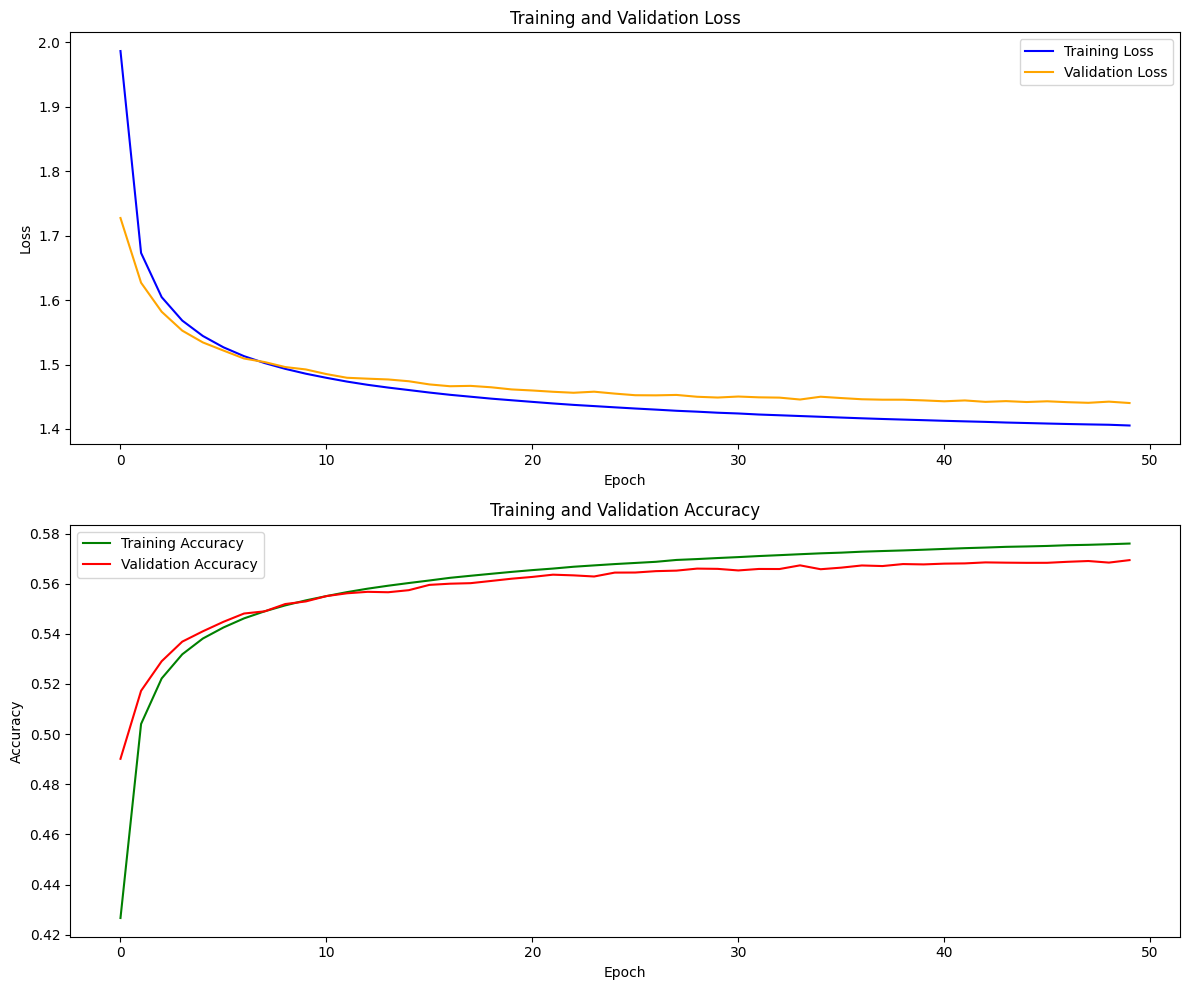

Average BLEU Score on Validation Data: 0.0134
Loaded weights from ./training_checkpoints/ckpt_9.weights.h5
Generated Text:

Once upon a midnight dreary deeds the gardens nowelcotch within a h kiss Her man will play which is this longed senite bearlo mirror very sudh now wing and is should in the hope reckoning us Umare you feel late uninexis It ends grow in the evening tale for no fear I hope strong tis I lay to love you shade The crimes unto as wing In ordare She cannicidaaverse has made your words of sky brought Received as a glory for you a wise I lie I do not ye and you thought all that flowers over human town in intent Whe down and fact W


In [ ]:
!pip install numpy tensorflow matplotlib scikit-learn nltk

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

train_data_path = '/kaggle/working/processed_poetry_train_dataset.csv'
val_data_path = '/kaggle/working/processed_poetry_val_dataset.csv'
train_df = pd.read_csv(train_data_path)
val_df = pd.read_csv(val_data_path)

train_df = train_df.dropna(subset=['Poem_Text'])
val_df = val_df.dropna(subset=['Poem_Text'])

train_df['Poem_Text'] = train_df['Poem_Text'].astype(str)
val_df['Poem_Text'] = val_df['Poem_Text'].astype(str)

text_corpus = ' '.join(train_df['Poem_Text'].tolist())

vocab = sorted(set(text_corpus))
vocab_size = len(vocab)

char2idx = {char: idx for idx, char in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[char] for char in text_corpus])

seq_length = 100
BATCH_SIZE = 64
BUFFER_SIZE = 10000
embedding_dim = 256
rnn_units = 512
EPOCHS = 50

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length + 1, drop_remainder=True)

def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

train_dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

val_corpus = ' '.join(val_df['Poem_Text'].tolist())
val_text_as_int = np.array([char2idx[char] for char in val_corpus if char in char2idx])

val_char_dataset = tf.data.Dataset.from_tensor_slices(val_text_as_int)
val_sequences = val_char_dataset.batch(seq_length + 1, drop_remainder=True)
val_dataset = val_sequences.map(split_input_target).batch(BATCH_SIZE, drop_remainder=True)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = Sequential([
        tf.keras.layers.InputLayer(batch_input_shape=(batch_size, None)),
        Embedding(vocab_size, embedding_dim),
        LSTM(rnn_units,
             return_sequences=True,
             stateful=True,
             recurrent_initializer='glorot_uniform'),
        Dense(vocab_size)
    ])
    return model

model = build_model(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

checkpoint_dir = './training_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}.weights.h5")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint_callback]
)

model.save('/kaggle/working/poetry_generation_model.h5')

def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    axs[0].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Training Accuracy', color='green')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

def compute_bleu_scores(model, dataset, num_batches=100):
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1

    lstm_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LSTM):
            lstm_layer = layer
            break

    if lstm_layer is None:
        print("No LSTM layer found in the model.")
        return 0.0

    lstm_layer.reset_states()

    for batch, (input_example, target_example) in enumerate(dataset.take(num_batches)):
        predictions = model(input_example)
        predicted_ids = tf.argmax(predictions, axis=-1).numpy()
        
        for i in range(predicted_ids.shape[0]):
            generated_text = ''.join(idx2char[predicted_ids[i]])
            reference_text = ''.join(idx2char[target_example[i].numpy()])
            
            generated_words = generated_text.split()
            reference_words = reference_text.split()
            
            if len(generated_words) == 0 or len(reference_words) == 0:
                continue
            score = sentence_bleu([reference_words], generated_words, smoothing_function=smooth_fn)
            bleu_scores.append(score)
        
        if batch >= num_batches - 1:
            break

    if len(bleu_scores) == 0:
        return 0.0
    return np.mean(bleu_scores)

bleu_score = compute_bleu_scores(model, val_dataset, num_batches=100)
print(f"Average BLEU Score on Validation Data: {bleu_score:.4f}")

def generate_text(model, start_string, num_generate=500):
    input_eval = [char2idx.get(s, 0) for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    text_generated = []

    temperature = 1.0

    lstm_layer = None
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.LSTM):
            lstm_layer = layer
            break

    if lstm_layer is None:
        print("No LSTM layer found in the model.")
        return start_string

    lstm_layer.reset_states()

    for i in range(num_generate):
        predictions = model(input_eval)
        predictions = tf.squeeze(predictions, 0)

        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

model_for_generation = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'ckpt_*.weights.h5'))

checkpoint_files.sort()
latest_checkpoint = checkpoint_files[-1] if checkpoint_files else None

if latest_checkpoint:
    model_for_generation.load_weights(latest_checkpoint)
    print(f"Loaded weights from {latest_checkpoint}")
else:
    print("No checkpoint found.")

model_for_generation.build(tf.TensorShape([1, None]))

sample_text = generate_text(model_for_generation, start_string="Once upon a midnight dreary")
print("Generated Text:\n")
print(sample_text)


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Epoch 1/4
78132/78132 ━━━━━━━━━━━━━━━━━━━━ 9013s 115ms/step - accuracy: 0.9116 - loss: 0.5851 - val_accuracy: 0.9400 - val_loss: 0.3748
Epoch 2/4
78132/78132 ━━━━━━━━━━━━━━━━━━━━ 9015s 115ms/step - accuracy: 0.9564 - loss: 0.2867 - val_accuracy: 0.9499 - val_loss: 0.3195
Epoch 3/4
78132/78132 ━━━━━━━━━━━━━━━━━━━━ 9013s 115ms/step - accuracy: 0.9573 - loss: 0.2778 - val_accuracy: 0.9507 - val_loss: 0.3177
Epoch 4/4
78132/78132 ━━━━━━━━━━━━━━━━━━━━ 9005s 115ms/step - accuracy: 0.9577 - loss: 0.2701 - val_accuracy: 0.9505 - val_loss: 0.3225


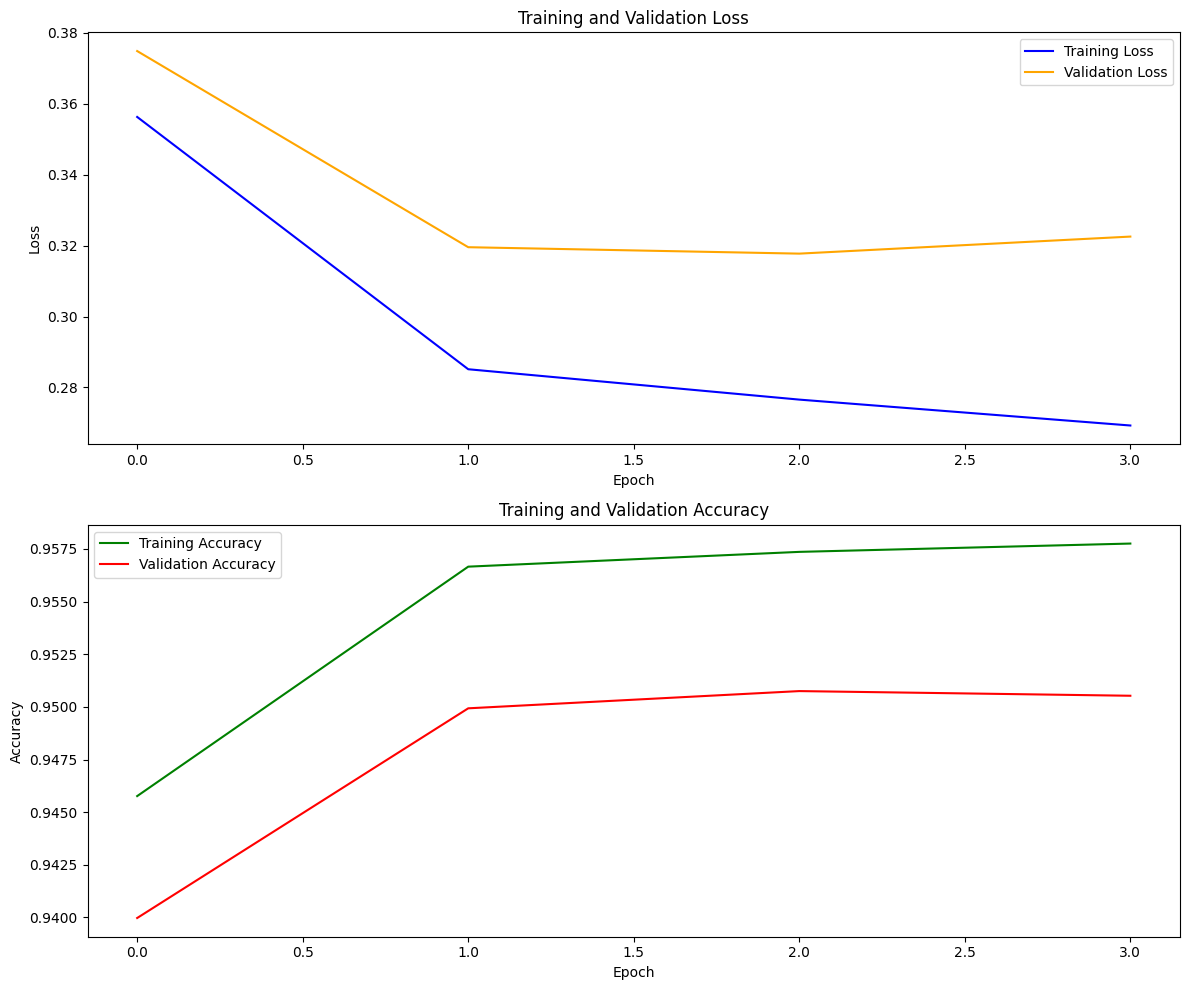

Average BLEU Score on Validation Data: 0.9349
Model loaded successfully for text generation.
Generated Text:

Once upon a midnight dreary day and night and bright as i am not aware that i can see i am not a star of love i have a place of joy to live and i am not alone but i have no words to be aware that i can not exist in the world

Generated Text after Post-processing:

Once upon a midnight dreary day and night and bright as i am not aware that i can see i am not a star of love i have a place of joy to live and i am not alone but i have no words to be aware that i can not exist in the world

Generated Text with Top-K Sampling:

Once upon a midnight dreary place of love that love the light and joy that love in life is in love with a blessing on earth a beauty that is a blessing on its wings a broken mirror is in the air and love of love is the beauty and love the heart and the

Generated Text with Top-K Sampling after Post-processing:

Once upon a midnight dreary place of love that lo

In [ ]:
!pip install numpy tensorflow matplotlib scikit-learn nltk syllapy

import numpy as np
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import syllapy
import nltk
from collections import Counter

nltk.download('punkt')

train_data_path = '/kaggle/working/processed_poetry_train_dataset.csv'
val_data_path = '/kaggle/working/processed_poetry_val_dataset.csv'
train_df = pd.read_csv(train_data_path)
val_df = pd.read_csv(val_data_path)

train_df = train_df.dropna(subset=['Poem_Text'])
val_df = val_df.dropna(subset=['Poem_Text'])

train_df['Poem_Text'] = train_df['Poem_Text'].astype(str)
val_df['Poem_Text'] = val_df['Poem_Text'].astype(str)

def tokenize_poems(poems):
    tokenized = [nltk.word_tokenize(poem.lower()) for poem in poems]
    return tokenized

train_tokens = tokenize_poems(train_df['Poem_Text'].tolist())
val_tokens = tokenize_poems(val_df['Poem_Text'].tolist())

train_words = [word for poem in train_tokens for word in poem]
val_words = [word for poem in val_tokens for word in poem]

MAX_VOCAB_SIZE = 20000

word_counts = Counter(train_words)

most_common = word_counts.most_common(MAX_VOCAB_SIZE - 1)
vocab = [word for word, count in most_common]

vocab.append("<UNK>")

vocab_size = len(vocab)

word2idx = {word: idx + 1 for idx, word in enumerate(vocab)}
word2idx["<PAD>"] = 0
idx2word = {idx: word for word, idx in word2idx.items()}

train_int = [word2idx.get(word, word2idx["<UNK>"]) for word in train_words]
val_int = [word2idx.get(word, word2idx["<UNK>"]) for word in val_words]

SEQ_LENGTH = 20
BATCH_SIZE = 32
BUFFER_SIZE = 10000
EMBEDDING_DIM = 256
LSTM_UNITS = 512
EPOCHS = 4

def create_sequences(word_indices, seq_length):
    sequences = []
    for i in range(len(word_indices) - seq_length):
        seq = word_indices[i:i + seq_length + 1]
        sequences.append(seq)
    return sequences

train_sequences = create_sequences(train_int, SEQ_LENGTH)
val_sequences = create_sequences(val_int, SEQ_LENGTH)

def split_input_target(seq):
    input_seq = seq[:-1]
    target_seq = seq[1:]
    return input_seq, target_seq

train_ds = tf.data.Dataset.from_tensor_slices(train_sequences)
train_ds = train_ds.map(split_input_target)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(val_sequences)
val_ds = val_ds.map(split_input_target)
val_ds = val_ds.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

def build_model(vocab_size, embedding_dim, lstm_units):
    model = Sequential([
        tf.keras.layers.InputLayer(shape=(None,)),
        Embedding(input_dim=vocab_size + 1, output_dim=embedding_dim, mask_zero=True),
        Bidirectional(LSTM(units=lstm_units, return_sequences=True)),
        Dense(units=vocab_size + 1, activation='softmax')
    ])
    return model

model = build_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    lstm_units=LSTM_UNITS
)

loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='/kaggle/working/poetry_generation_model.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min'
)

earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[checkpoint_callback, earlystopping_callback]
)

def plot_history(history):
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))

    axs[0].plot(history.history['loss'], label='Training Loss', color='blue')
    axs[0].plot(history.history['val_loss'], label='Validation Loss', color='orange')
    axs[0].set_title('Training and Validation Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(history.history['accuracy'], label='Training Accuracy', color='green')
    axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    axs[1].set_title('Training and Validation Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

def compute_bleu_scores(model, dataset, num_batches=100):
    bleu_scores = []
    smooth_fn = SmoothingFunction().method1

    for batch, (input_example, target_example) in enumerate(dataset.take(num_batches)):
        predictions = model.predict(input_example, verbose=0)
        predicted_ids = np.argmax(predictions, axis=-1)

        for i in range(predicted_ids.shape[0]):
            generated_words = [idx2word.get(idx, "") for idx in predicted_ids[i]]
            reference_words = [idx2word.get(idx, "") for idx in target_example[i].numpy()]

            if len(generated_words) == 0 or len(reference_words) == 0:
                continue
            score = sentence_bleu([reference_words], generated_words, smoothing_function=smooth_fn)
            bleu_scores.append(score)

        if batch >= num_batches - 1:
            break

    if len(bleu_scores) == 0:
        return 0.0
    return np.mean(bleu_scores)

bleu_score = compute_bleu_scores(model, val_ds, num_batches=100)
print(f"Average BLEU Score on Validation Data: {bleu_score:.4f}")

def generate_text(model, start_string, num_generate=50, beam_width=3):
    input_words = [word2idx.get(word, word2idx["<UNK>"]) for word in nltk.word_tokenize(start_string.lower())]
    input_eval = tf.expand_dims(input_words, 0)

    text_generated = []

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = predictions[:, -1, :]
        predictions = predictions / 1.0

        predictions_np = predictions.numpy()[0]

        unk_index = word2idx.get("<UNK>")
        if unk_index is not None:
            predictions_np[unk_index] = -np.inf

        predicted_ids = np.argsort(predictions_np)[-beam_width:]
        selected_id = predicted_ids[np.random.randint(len(predicted_ids))]

        generated_word = idx2word.get(selected_id, "")
        if generated_word == "":
            break
        text_generated.append(generated_word)

        input_eval = tf.concat([input_eval, tf.expand_dims([selected_id], 0)], axis=1)

    return start_string + ' ' + ' '.join(text_generated)

def generate_text_top_k(model, start_string, num_generate=50, top_k=5):
    input_words = [word2idx.get(word, word2idx["<UNK>"]) for word in nltk.word_tokenize(start_string.lower())]
    input_eval = tf.expand_dims(input_words, 0)

    text_generated = []

    for _ in range(num_generate):
        predictions = model(input_eval)
        predictions = predictions[:, -1, :]
        predictions = predictions / 1.0

        predictions_np = predictions.numpy()[0]

        unk_index = word2idx.get("<UNK>")
        if unk_index is not None:
            predictions_np[unk_index] = -np.inf

        top_k_indices = predictions_np.argsort()[-top_k:]
        top_k_probs = predictions_np[top_k_indices]
        top_k_probs = top_k_probs - np.max(top_k_probs)
        top_k_probs = np.exp(top_k_probs)
        top_k_probs = top_k_probs / np.sum(top_k_probs)

        selected_id = np.random.choice(top_k_indices, p=top_k_probs)

        generated_word = idx2word.get(selected_id, "")
        if generated_word == "":
            break
        text_generated.append(generated_word)

        input_eval = tf.concat([input_eval, tf.expand_dims([selected_id], 0)], axis=1)

    return start_string + ' ' + ' '.join(text_generated)

def post_process_text(generated_text):
    words = generated_text.split()
    processed_words = [word for word in words if word != "<UNK>"]
    return ' '.join(processed_words)

model_loaded = tf.keras.models.load_model('/kaggle/working/poetry_generation_model.keras')
print("Model loaded successfully for text generation.")

start_string = "Once upon a midnight dreary"
sample_text = generate_text(model_loaded, start_string, num_generate=50)
print("Generated Text:\n")
print(sample_text)

sample_text_processed = post_process_text(sample_text)
print("\nGenerated Text after Post-processing:\n")
print(sample_text_processed)

sample_text_top_k = generate_text_top_k(model_loaded, start_string, num_generate=50, top_k=5)
print("\nGenerated Text with Top-K Sampling:\n")
print(sample_text_top_k)

sample_text_top_k_processed = post_process_text(sample_text_top_k)
print("\nGenerated Text with Top-K Sampling after Post-processing:\n")
print(sample_text_top_k_processed)

def add_rhythm_constraints(generated_text):
    words = nltk.word_tokenize(generated_text)
    syllable_counts = [syllapy.count(word) for word in words]
    total_syllables = sum(syllable_counts)
    return generated_text

sample_text_with_rhythm = add_rhythm_constraints(sample_text_processed)
print("\nGenerated Text with Rhythm Constraints:\n")
print(sample_text_with_rhythm)
